# Tailing notebook

In [6]:
import pickle
# Load the pickle files for threshold 15
vsl_total = pickle.load(open("logger-vsl.pkl", "rb"))
novsl_total = pickle.load(open("logger-novsl.pkl", "rb"))

[2500, 2783.69231]
[2783.69231, 2926.46154]
[2926.46154, 3576.30769]
[3576.30769, 3758.46154]
[3758.46154, 4000]
Fit points [(2600.0, 346.13889), (2681.53846, 361.94444), (2766.15385, 372.5), (2800.0, 378.27778), (2853.84615, 395.55556), (2875.0, 390.90278), (2944.61538, 400.51389), (3038.46154, 415.47222), (3135.38462, 429.73611), (3235.38462, 454.18056), (3338.46154, 503.125), (3444.61538, 546.125), (3553.84615, 584.81944), (3625.0, 604.84722), (3666.15385, 678.40278), (3700.0, 699.59722), (3781.53846, 730.69444), (3900.0, 784.58333)]
FIT POINT: (2600.0, 346.13889)
FIT POINT: (2681.53846, 361.94444)
FIT POINT: (2766.15385, 372.5)
FIT POINT: (2800.0, 378.27778)
FIT POINT: (2853.84615, 395.55556)
FIT POINT: (2875.0, 390.90278)
FIT POINT: (2944.61538, 400.51389)
FIT POINT: (3038.46154, 415.47222)
FIT POINT: (3135.38462, 429.73611)
FIT POINT: (3235.38462, 454.18056)
FIT POINT: (3338.46154, 503.125)
FIT POINT: (3444.61538, 546.125)
FIT POINT: (3553.84615, 584.81944)
FIT POINT: (3625.0, 60

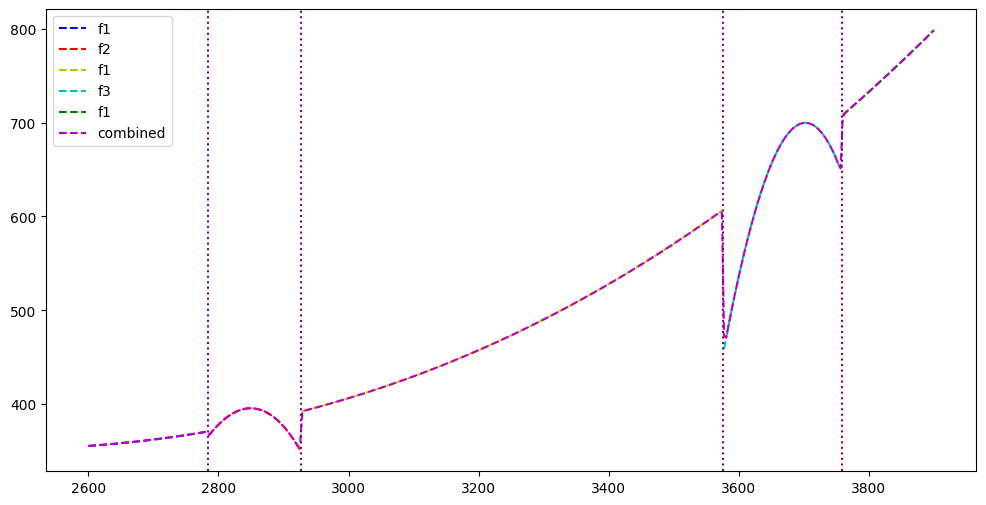

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import re
import os
import decimal
import math
os.environ['INSTANCE_NAME'] = 'VSL_script_hell_die'
from global_settings import mds,vfs
import matplotlib.pyplot as plt
import numpy as np
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# Set font for the figure
# plt.rcParams.update({'font.size': 14})

_, ax = plt.subplots(figsize=(12, 6))
# Create graph for vsl
funcs = []
functions = []

def get_coefficients(interval):
    # Convert the string into a function array of terms
    terms = re.findall(r'([+-]?\s*\d+\.?\d*(?:e[+-]?\d+)?)(x\^\d+)?', interval['fitting_function'].replace(' ', ''))
    # For each element if x present, we extract exponent
    coefficients = [0] * (vfs['max_deg']+1)  # Initialize a list for coefficients
    for term in terms:
        coef = float(term[0])
        if term[1]:  # If there is an 'x' term
            exponent = int(term[1][2:])  # Get the exponent
            while len(coefficients) <= exponent:  # Expand the list if needed
                coefficients.append(0)
            # Assign the coefficient to the corresponding position in the list
            coefficients[exponent] = coef
        else:  # If there is no 'x' term, it's the constant term
            coefficients[0] = coef
    return coefficients

connection_points = []
labels = []
points = []
for element in vsl_total:
    interval = element['interval']
    print(interval)
    fitting_function_str = element['fitting_function']
    labels.append(fitting_function_str)
    [points.append(i) for i in element['fit_points']]
    
    coefficients = get_coefficients(element)
    fitting_function = np.poly1d(coefficients[::-1])

    funcs.append(fitting_function)
    
    if interval[1] != mds["domain_max_interval"]:
        connection_points.append(interval[1])
x_point = []
y_point = []
print(f"Fit points {points}")
for fit_point in points:
    print(f"FIT POINT: {fit_point}")
    x_point.append(fit_point[0])
    y_point.append(fit_point[1])


x = np.linspace(2600,3900,400,dtype=np.float128)



# Compute the y values for each function
y_values = [f(x) for f in funcs]
# Initialize the combined function as the first function
y = y_values[0]


# Define the transition function (sigmoid)
def transition(l, l_conn, width=1):
    return 1 / (1 + np.exp(-2/width*(l - l_conn)))


# Iterate over the remaining functions
for i in range(1, len(funcs)):
    # Compute the transition values
    t = transition(x, connection_points[i-1])

    # Update the combined function
    y = (1 - t) * y + t * y_values[i]
    print(t)

print(y)
# Plot the functions and the combined function
labels = ['f1','f2','f1','f3','f1']
# colors = ['b', 'r', 'y', 'c','g','y','b','m']
colors = ['b', 'r', 'y', 'c','g']
print(connection_points)
for i in range(len(funcs)):
    if i == 0:
        plt.plot(x[x<=connection_points[i]], y_values[i][x<=connection_points[i]], colors[i]+'--', label=labels[i])
    elif i == len(funcs) - 1:
        plt.plot(x[x>=connection_points[i-1]], y_values[i][x>=connection_points[i-1]], colors[i]+'--', label=labels[i])
    else:
        plt.plot(x[(x>=connection_points[i-1]) & (x<connection_points[i])], y_values[i][(x>=connection_points[i-1]) & (x<connection_points[i])], colors[i]+'--', label=labels[i])

plt.plot(x, y, 'm--', label='combined')
for x_conn in connection_points:
    plt.axvline(x=x_conn, color='purple', linestyle=':')
plt.legend()
plt.show()

In [7]:
import re
import os
os.environ['INSTANCE_NAME'] = 'VSL_script_TEST'
import warnings
# warnings.filterwarnings("error")
import matplotlib.pyplot as plt
import numpy as np
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

from global_settings import ops, mds, vfs

from dataclasses import dataclass
from typing import Tuple, List

@dataclass
class FittedFunction:
    """Class for keeping track fitted functions."""
    name: str
    interval: Tuple[float, float]
    func_form: float
    fitted_points: List[Tuple[float,float]]
    # color: str
    
    # def get_color(self) -> str:
    #     return self.color
    
    def get_interval(self) -> Tuple[float, float]:
        return self.interval


@dataclass
class FunctionValues:
    name: str
    x_values: np.ndarray
    y_values: np.ndarray
    

def get_coefficients(interval):
    # Convert the string into a function array of terms
    terms = re.findall(r'([+-]?\s*\d+\.?\d*(?:e[+-]?\d+)?)(x\^\d+)?', interval['fitting_function'].replace(' ', ''))
    # For each element if x present, we extract exponent
    coefficients = [0] * (vfs['max_deg']+1)  # Initialize a list for coefficients
    for term in terms:
        coef = float(term[0])
        if term[1]:  # If there is an 'x' term
            exponent = int(term[1][2:])  # Get the exponent
            while len(coefficients) <= exponent:  # Expand the list if needed
                coefficients.append(0)
            # Assign the coefficient to the corresponding position in the list
            coefficients[exponent] = coef
        else:  # If there is no 'x' term, it's the constant term
            coefficients[0] = coef
    return coefficients

def _plot_results_tailing(all_fit_intervals_data, remaining_unfit_intervals = []):
    # Create graph
    _, ax = plt.subplots(figsize=(ops['figsize_x'], ops['figsize_y']))
    # Remember color for the same fitted functions
    points = []
    funcs = []
    connection_points = []
    funcs_values = []
    # Create x values
    x = np.linspace(mds["domain_min_interval"], mds["domain_max_interval"], 600)
    # Save labels and points for the fitting functions
    for element in all_fit_intervals_data:
        # Get coefficients
        coefficients = get_coefficients(element)
        fitting_function = np.poly1d(coefficients[::-1])
        f = FittedFunction(name=element['fitting_function'], interval=element['interval'],
                           func_form=fitting_function,
                           fitted_points=[points.append(i) for i in element['fit_points']])
        funcs.append(f)
        x_temp = x[np.logical_and(x >= f.interval[0], x <= f.interval[1])]
        f_values = FunctionValues(name=element['fitting_function'],
                                  x_values=x[np.logical_and(x >= f.interval[0], x <= f.interval[1])],
                                  y_values=np.array([f.func_form(el) for el in x_temp]))
        funcs_values.append(f_values)

        if f.interval[1] != mds["domain_max_interval"]:
            connection_points.append(f.interval[1])

    if ops['predicted_points']:
        x_point = []
        y_point = []
        for fit_point in points:
            print(f"FIT POINT: {fit_point}")
            x_point.append(fit_point[0])
            y_point.append(fit_point[1])

    def transition(x, x_conn, width=ops['sigmoid_width']):
        return 1.0 / (1.0 + np.exp(-2 / width * (x - x_conn)))

    # Fit the y values for the generated x
    y_values = [f.func_form(x) for f in funcs]
    # Initialize the first function as base for the combined
    y = y_values[0]

    # Iterate over the remaining functions
    for i in range(1, len(funcs)):
        # Compute the transition values
        t = transition(x, connection_points[i - 1])
        # Update the combined function
        y = (1 - t) * y + t * y_values[i]

    colors = {}
    for i in range(0, len(funcs)):
        custom_label = f"Interval: [{funcs[i].interval[0]},{funcs[i].interval[1]}]"
        if funcs[i].name in colors.keys():
            ax.plot(funcs_values[i].x_values, funcs_values[i].y_values, label=custom_label,
                    color=colors[funcs[i].name], linewidth=2)
        else:
            ax.plot(funcs_values[i].x_values, funcs_values[i].y_values, label=custom_label, linewidth=2)
            color = ax.get_lines()[-1].get_color()
            colors[funcs[i].name] = color

    for element in remaining_unfit_intervals:
        ax.axvspan(*element['interval'], color='gray',
                   alpha=0.3, label='unfit Interval')
    ax.plot(x, y, 'r--', label='smoothened', linewidth=2)

    for x_conn in connection_points:
        ax.axvline(x=x_conn, color='purple', linestyle=':')

    if ops['predicted_points']:
        ax.plot(x_point, y_point, "ro", label="original points")
    plt.xlabel(ops['x_labels'])
    plt.ylabel(ops['y_labels'])
    plt.title(ops['title'])
    plt.legend()
    plt.show()

FIT POINT: (2600.0, 346.13889)
FIT POINT: (2681.53846, 361.94444)
FIT POINT: (2766.15385, 372.5)
FIT POINT: (2800.0, 378.27778)
FIT POINT: (2853.84615, 395.55556)
FIT POINT: (2875.0, 390.90278)
FIT POINT: (2944.61538, 400.51389)
FIT POINT: (3038.46154, 415.47222)
FIT POINT: (3135.38462, 429.73611)
FIT POINT: (3235.38462, 454.18056)
FIT POINT: (3338.46154, 503.125)
FIT POINT: (3444.61538, 546.125)
FIT POINT: (3553.84615, 584.81944)
FIT POINT: (3625.0, 604.84722)
FIT POINT: (3666.15385, 678.40278)
FIT POINT: (3700.0, 699.59722)
FIT POINT: (3781.53846, 730.69444)
FIT POINT: (3900.0, 784.58333)


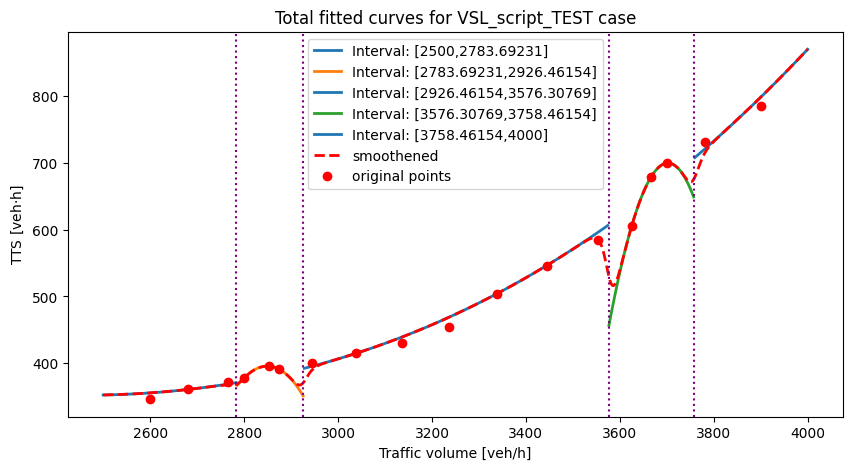

In [8]:
_plot_results_tailing(vsl_total)

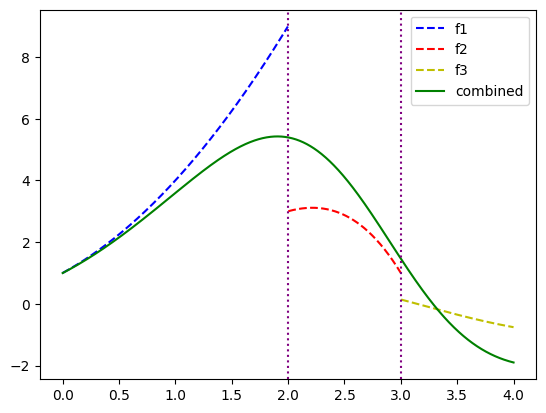

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define the polynomial functions
def f1(x):
    return x**2 + 2*x + 1

def f2(x):
    return -x**3 + 4*x**2 - 3*x + 1

def f3(x):
    return np.sin(x)

# Put the functions in a list
functions = [f1, f2, f3]

# Define the connection points
connection_points = [2, 3]

# Define the x values
x = np.linspace(0, 4, 1000)

# Compute the y values for each function
y_values = [f(x) for f in functions]

# Define the transition function (sigmoid)
def transition(x, x_conn, width=1):
    return 1 / (1 + np.exp(-2/width*(x - x_conn)))

# Initialize the combined function as the first function
y = y_values[0]

# Iterate over the remaining functions
for i in range(1, len(functions)):
    # Compute the transition values
    t = transition(x, connection_points[i-1])

    # Update the combined function
    y = (1 - t) * y + t * y_values[i]

# Plot the functions and the combined function
colors = ['b', 'r', 'y']
labels = ['f1', 'f2', 'f3']
for i in range(len(functions)):
    if i == 0:
        plt.plot(x[x<=connection_points[i]], y_values[i][x<=connection_points[i]], colors[i]+'--', label=labels[i])
    elif i == len(functions) - 1:
        plt.plot(x[x>=connection_points[i-1]], y_values[i][x>=connection_points[i-1]], colors[i]+'--', label=labels[i])
    else:
        plt.plot(x[(x>=connection_points[i-1]) & (x<connection_points[i])], y_values[i][(x>=connection_points[i-1]) & (x<connection_points[i])], colors[i]+'--', label=labels[i])
plt.plot(x, y, 'g-', label='combined')
for x_conn in connection_points:
    plt.axvline(x=x_conn, color='purple', linestyle=':')
plt.legend()
plt.show()